## Step 1 - Import proper libraries

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit 
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)

2025-12-04 05:31:06.792392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764826267.099563      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764826267.201474      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2 - Look at the data|

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission =  pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


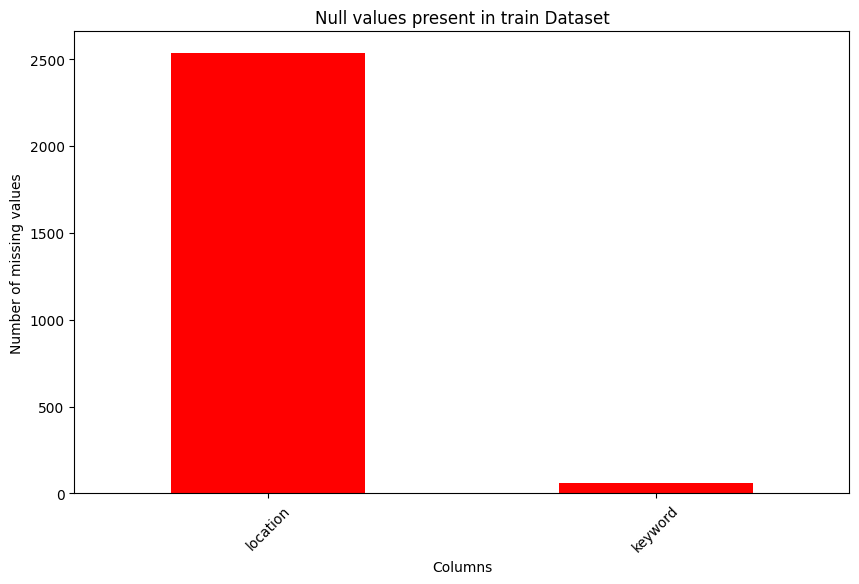

In [6]:
import matplotlib.pyplot as plt

# Count missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
missing.plot(kind='bar', color='red')
plt.title('Null values present in train Dataset')
plt.ylabel('Number of missing values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

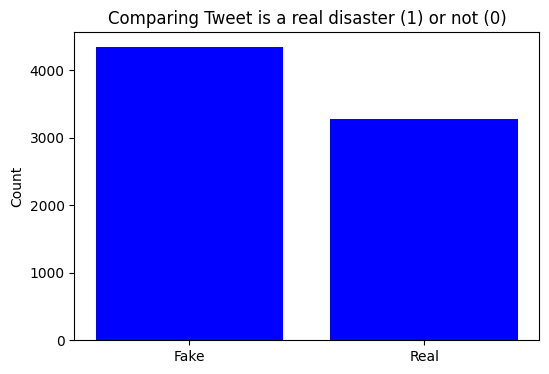

In [7]:
counts = train['target'].value_counts()
labels = ['Fake', 'Real']  # replace text argument

plt.figure(figsize=(6,4))
plt.bar(labels, counts.values, color='blue')
plt.title('Comparing Tweet is a real disaster (1) or not (0)')
plt.ylabel('Count')
plt.show()

In [8]:
train['length'] = train['text'].apply(len)

In [9]:
train.keyword.nunique()

221

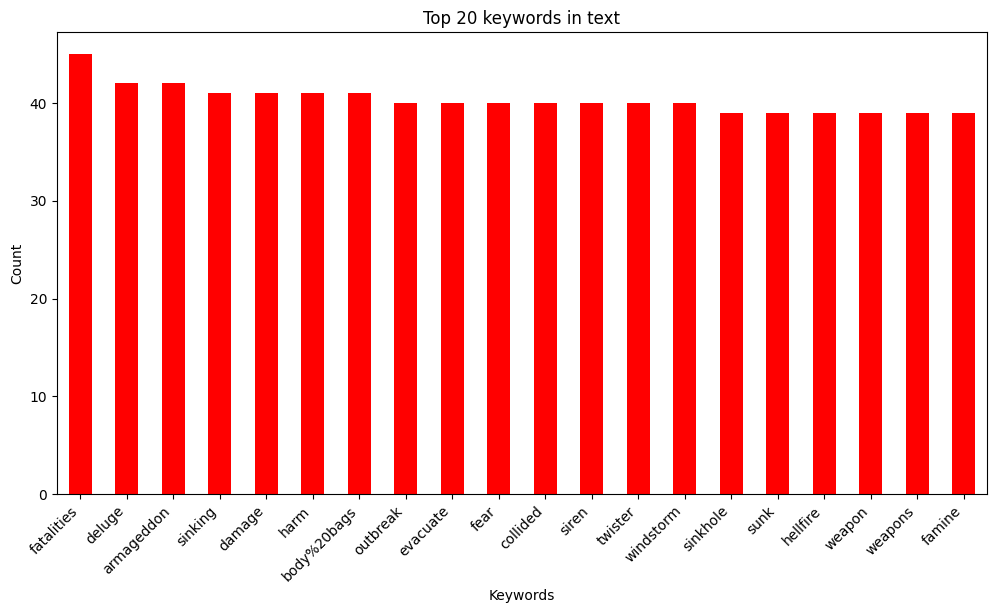

In [10]:
top_keywords = train['keyword'].value_counts().iloc[:20]

plt.figure(figsize=(12,6))
top_keywords.plot(kind='bar', color='red')
plt.title('Top 20 keywords in text')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

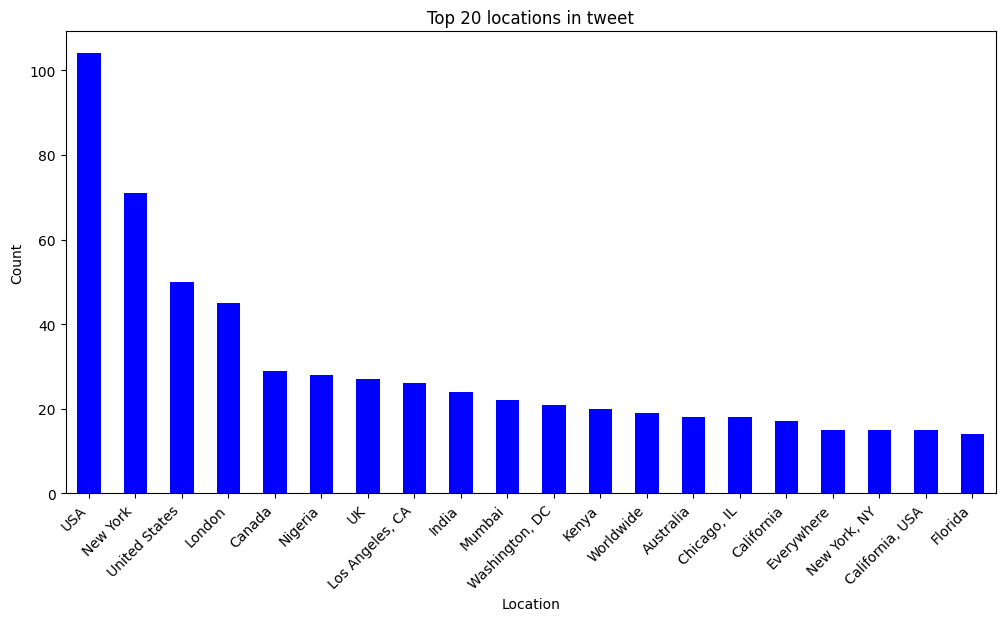

In [11]:
top_locations = train['location'].value_counts().iloc[:20]

plt.figure(figsize=(12,6))
top_locations.plot(kind='bar', color='blue')
plt.title('Top 20 locations in tweet')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

## Step 3 -  Most appearing words

In [12]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

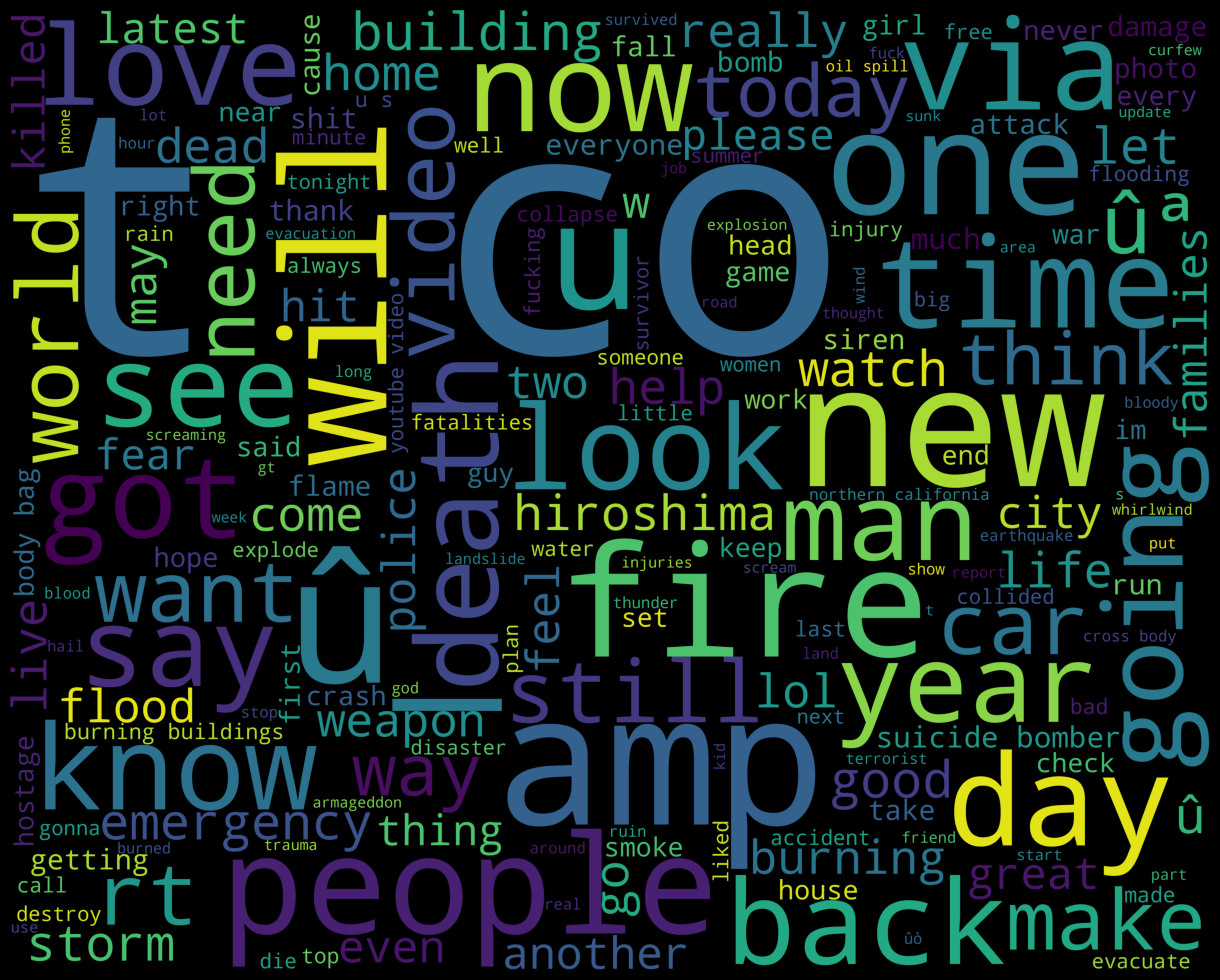

In [13]:
text = train.text.values

Plot_world(text)

## Step 4 - Time to clean the text

In [14]:
#How many http words has this text?

train.loc[train['text'].str.contains('http')].target.value_counts()

target
1    2172
0    1799
Name: count, dtype: int64

In [15]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [16]:
# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [17]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].target.value_counts()

target
0    1
Name: count, dtype: int64

In [18]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

## Step 5 - Time to remove the stopwords and add a lower delimiter

In [19]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

In [20]:
text = train.text[3]
print(text)
clean_text(text)

13,000 people receive #wildfires evacuation orders in California 


'people receive wildfires evacuation orders california'

In [21]:
# Apply clean text on train
train['text'] = train['text'].apply(lambda x : clean_text(x))

In [22]:
# Apply clean text on test
test['text']=test['text'].apply(lambda x : clean_text(x))

In [23]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [24]:
text_values = train["text"]

counter = counter_word(text_values)

In [25]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

## Step 6 -  Train Test Split time

In [26]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [27]:
training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [28]:
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (6090,)
The Shape of testing (1523,)


In [29]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [30]:
word_index = tokenizer.word_index

In [31]:
#Lets check the first few elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))


THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 
 one,  11 
 disaster,  12 
 body,  13 
 video,  14 
 burning,  15 


In [32]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
print(train.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[74, 4, 120, 571, 5480, 5481, 1184]


# Step 7 - Time to Inverse the word mapping so it can read back the words after prediction

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [35]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  via 
 7,  new 
 8,  people 
 9,  news 
 10,  emergency 
 11,  one 
 12,  disaster 
 13,  body 
 14,  video 
 15,  burning 


In [36]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [37]:
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [38]:
training_padded[1628]

array([7779, 1150, 2107,  629, 2106, 1257,   52,  326, 2106, 1257,   52,
        326, 7780,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [39]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Step 8 - Time to create the model

In [40]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2025-12-04 05:32:44.029970: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [41]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5965 - loss: 0.6471 - val_accuracy: 0.7859 - val_loss: 0.4602
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8857 - loss: 0.2992 - val_accuracy: 0.7951 - val_loss: 0.4633
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9403 - loss: 0.1779 - val_accuracy: 0.7715 - val_loss: 0.5286
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9639 - loss: 0.1193 - val_accuracy: 0.7190 - val_loss: 0.7393
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9725 - loss: 0.0973 - val_accuracy: 0.7295 - val_loss: 0.6796
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9775 - loss: 0.0698 - val_accuracy: 0.7196 - val_loss: 0.7642
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9780 - loss: 0.0634 - val_accuracy: 0.7269 - val_loss: 0.6936
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9790 - loss: 0.0545 - val_acc

In [43]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,accuracy,loss,val_accuracy,val_loss
0,0.687192,0.569872,0.785949,0.460194
1,0.883087,0.305988,0.795141,0.463309
2,0.939245,0.180209,0.771504,0.528560
3,0.959113,0.125297,0.718976,0.739341
4,0.968637,0.100322,0.729481,0.679600


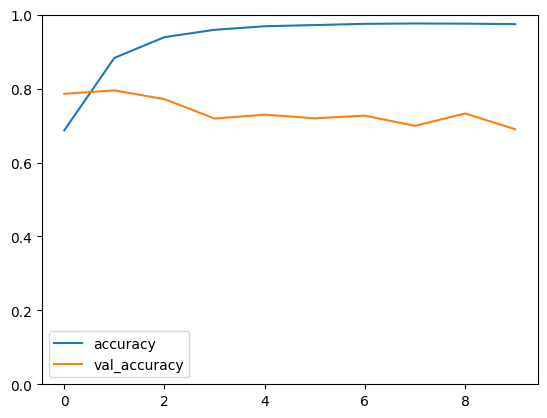

In [44]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);


# Step 9 - Model evaluation

In [53]:
predictions = model.predict(testing_padded)   # predict_ clases because is classification problem with the split test
np.argmax(predictions, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [54]:
predictions = predictions.astype('int')

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

/tmp/ipykernel_47/3250564746.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



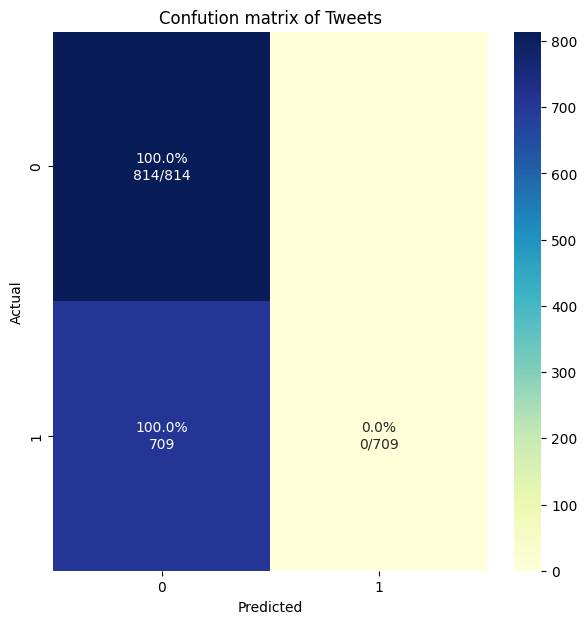

In [56]:
# Showing Confusion Matrix
plot_cm(testing_labels,predictions, 'Confution matrix of Tweets', figsize=(7,7))

In [57]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
predictions = model.predict(testing_padded2)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [59]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Step 10 - Time to submit!

In [60]:
submission['target'] = (predictions > 0.5).astype(int)


In [61]:
submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [62]:
submission.to_csv("submission.csv", index=False, header=True)
